In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import ast
from scipy.stats import ttest_rel
import math
import seaborn as sns

ACTIVE_SHAM = 'Active'
GROUP1 = 'PRE'
GROUP2 = 'POST'
mapping = {0: 'theta', 1: 'alpha', 2: 'beta'}

DF                        index       swn                                \
                       index  theta-g1  theta-g2  alpha-g1  alpha-g2   
1   Active-Hemlata-PrevsPost       NaN       NaN       NaN       NaN   
2     Active-Malti-PrevsPost  0.328033  0.165424  0.367314  0.286433   
3    Active-Preeti-PrevsPost       NaN       NaN  0.250996  0.398823   
4   Active-Sharifa-PrevsPost  0.411041  0.318595  0.351765  0.243765   
5    Active-Vinita-PrevsPost  0.505946  0.353311  0.519844  0.309701   
6       Active-VKS-PrevsPost  0.280962  0.157745  0.103466  0.193431   
7      Active-Nitu-PrevsPost  0.130526  0.382258  0.017914  0.382258   
8   Active-Ranjeet-PrevsPost  0.439336  0.374283  0.343470  0.000000   
9    Active-Resham-PrevsPost  0.318990  0.412563  0.384051  0.487908   
10   Active-Rithik-PrevsPost  0.241701  0.380621  0.222955  0.322128   
11    Active-Rohan-PrevsPost  0.446681  0.339589  0.288658  0.177686   
12    Active-Suman-PrevsPost  0.359716  0.468919  0.297762  0

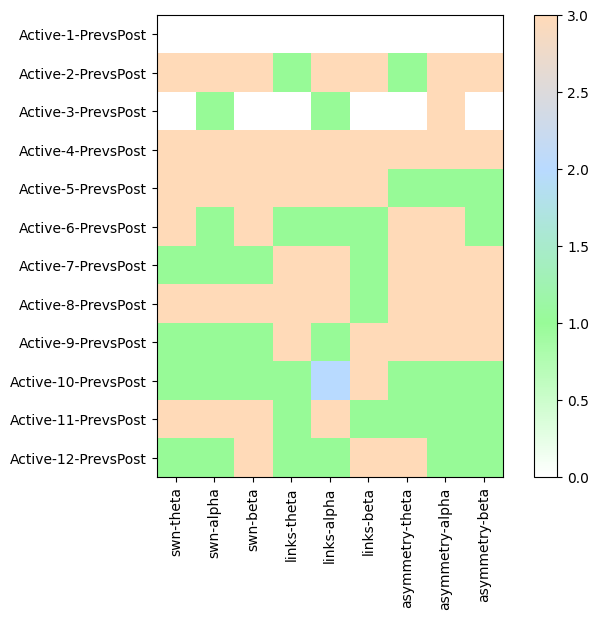

In [23]:
existing_file = f"comparison-results/result-{ACTIVE_SHAM}.xlsx"
df = pd.read_excel(existing_file, header=[0,1])

df_without_rows = df.drop(df.index[0:len(df)//2-5])
df_without_columns = df_without_rows.drop(df_without_rows.columns[0:len(df)//2-5], axis=1)
df = df_without_columns
print("DF", df)

colors = [(1, 1, 1), (0.596, 0.984, 0.596),  (0.725, 0.855, 1.000), (1.000, 0.855, 0.725)] # white, green, blue, red
values = [0, 1, 2, 3]
cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors, N=256)

# 0 : If swi values NaN ----- white
# 1 : If post swi > pre swi, post links > pre links, post asymmetry < pre asymmetry ----- green
# 2 : If post swi == pre swi, |post links - pre links| < 3, post asymmetry == pre asymmetry ---- blue
# 3 : If post swi < pre swi, post links < pre links, post asymmetry > pre asymmetry ----- red

condition_matrix = np.zeros((len(df), (len(df.columns)-10) // 2))
for j in range(len(df)): # rows
    insignificant_bands  = []
    for i in range(1, len(df.columns)-10, 2): # cols  
        # SWN  
        if i in range(1,6):
            if np.isnan(df.iloc[j, i]):
                condition_matrix[j, i // 2] = 0 # white
                insignificant_bands.append(i)
            # else:
            elif df.iloc[j, i] < df.iloc[j, i + 1]: 
                condition_matrix[j, i // 2] = 1 # green
            elif np.abs(df.iloc[j, i] - df.iloc[j, i + 1]) == 0:
                condition_matrix[j, i // 2] = 2 # blue
                # insignificant_bands.append(i)
            else:
                condition_matrix[j, i // 2] = 3 # red
        # LINKS
        elif i in range(6,12):
            if i-6 in insignificant_bands:
                condition_matrix[j, i // 2] = 0 # white
            elif np.abs(df.iloc[j, i] - df.iloc[j, i + 1]) <= 3: # links difference <= 5
                condition_matrix[j, i // 2] = 2 # blue
            elif df.iloc[j, i] < df.iloc[j, i + 1]:
                condition_matrix[j, i // 2] = 1 # green 
            else:
                condition_matrix[j, i // 2] = 3 # red
        # ASYMMETRY
        elif i in range(12,18):
            if i-12 in insignificant_bands:
                condition_matrix[j, i // 2] = 0 # white
            # else:
            elif np.abs(df.iloc[j, i] - 1) > np.abs(df.iloc[j, i+1] - 1): 
                condition_matrix[j, i//2] = 1 # green
            elif np.abs(df.iloc[j, i] - 1) == np.abs(df.iloc[j, i+1] - 1): 
                condition_matrix[j, i//2] = 2 # blue
            else:
                condition_matrix[j, i//2] = 3 # red


lis = [f"{df.columns[i][0]}-{df.columns[i][1].split('-')[0]}" for i in range(1, len(df.columns)-10, 2)]
y_list = [f"{elem.split('-')[0]}-{i+1}-{elem.split('-')[-1]}" for i, elem in enumerate(list(df.iloc[:, 0]))]

plt.figure(figsize=(8, 6))
plt.imshow(condition_matrix, cmap=cmap)
plt.xticks(range(((len(df.columns)-10)// 2)), lis, rotation='vertical')
plt.yticks(range(len(df)), y_list)
plt.colorbar()
plt.show()

In [5]:
# existing_file = f"comparison-results/result-Active.xlsx"
# df = pd.read_excel(existing_file, header=[0,1])
# df_without_rows = df.drop(df.index[0:len(df)//2+1])
# df_without_columns = df_without_rows.drop(df_without_rows.columns[0:len(df)//2+1], axis=1)
# active_data = df_without_columns
# existing_file = f"comparison-results/result-Sham.xlsx"
# df = pd.read_excel(existing_file)
# df_without_rows = df.drop(df.index[0:len(df)//2+1])
# df_without_columns = df_without_rows.drop(df_without_rows.columns[0:len(df)//2+1], axis=1)
# sham_data = df_without_columns

# combined_data = pd.concat([active_data, sham_data], axis=0)


# # Add the new row to the DataFrame
# for index, row in active_data.iterrows():
#     # print(f"Row {index}:\n{row}\n")
#     print(len(active_data))
#     active_data.loc[len(active_data)] = row

# print(active_data)

# Assuming 'combined_data' is your DataFrame
# print(tabulate(combined_data, headers='keys', tablefmt='psql'))


# # Create a DataFrame with your data
# data = {
#     'group': ['active']*12 + ['placebo']*6,
#     'small_worldedness': [1.2, 1.3, 1.4, 1.1, 1.5, 1.6, 1.2, 1.3, 1.4, 1.1, 1.2, 1.3, 1.4, 1.1, 1.2, 1.3, 1.4, 1.1, 1.2, 1.3],
#     'num_links': [100, 110, 95, 105, 115, 90, 100, 110, 95, 105, 100, 110, 95, 105, 100, 110, 95, 105, 100, 110],
#     'asymmetry': [0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2],
#     'brain_region': ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B']
# }
# df = pd.DataFrame(data)

# # Fit a linear regression model
# model = smf.ols(formula='small_worldedness ~ group + num_links + asymmetry + brain_region', data=df)
# results = model.fit()

# # Print the regression results
# print(results.summary())


# Assuming you have loaded the data into DataFrames active_data and sham_data

# Combine the data into a single DataFrame

# # Assume 'SWI' is the dependent variable and 'freq_band_1_g1' and 'freq_band_1_g2' are independent variables
# X = combined_data[['freq_band_1_g1', 'freq_band_1_g2']]
# X = sm.add_constant(X)  # Add a constant term to the independent variables
# y = combined_data['SWI']

# # Fit the linear regression model
# model = sm.OLS(y, X).fit()

# # Print the model summary
# print(model.summary())


In [24]:
swn_values1, swn_values2 = {'theta' : [], 'alpha': [], 'beta': []} , {'theta' : [], 'alpha': [], 'beta': []}
asymmetry_values1, asymmetry_values2 = {'theta' : [], 'alpha': [], 'beta': []}, {'theta' : [], 'alpha': [], 'beta': []}
links_values1, links_values2 = {'theta' : [], 'alpha': [], 'beta': []}, {'theta' : [], 'alpha': [], 'beta': []}
hub_values1, hub_values2 = {'theta' : [], 'alpha': [], 'beta': []}, {'theta' : [], 'alpha': [], 'beta': []}

master_dict = {'swn_values': [swn_values1, swn_values2], 'asymmetry_values': [asymmetry_values1, asymmetry_values2], \
               'links_values': [links_values1, links_values2], 'hub_values': [hub_values1, hub_values2]}

for j in range(len(df)): # rows
    for k in range(1, len(df.columns)-10, 2): # cols 
        print(k, df.iloc[j, k])
        # SWN  
        if k in range(1,6):
            para = 'swn_values'
        elif k in range(6, 12):
            para = 'links_values'
        elif k in range(12, 18):
            para = 'asymmetry_values'

        if k%6 == 1:
            master_dict[para][0]['theta'].append(df.iloc[j, k])
            master_dict[para][1]['theta'].append(df.iloc[j, k+1])
        elif k%6 == 3:
            master_dict[para][0]['alpha'].append(df.iloc[j, k])
            master_dict[para][1]['alpha'].append(df.iloc[j, k+1])
        elif k%6 == 5:
            master_dict[para][0]['beta'].append(df.iloc[j, k])
            master_dict[para][1]['beta'].append(df.iloc[j, k+1])

    
        # for k in range(len(df.columns)-6, len(df.columns)-3, 1): #cols
        #     print(k, "&&&&&&&")
        #     print(len(ast.literal_eval(df.iloc[j, k])))

1 nan
3 nan
5 nan
7 27.0
9 34.0
11 30.0
13 1.69230769230769
15 2.16666666666667
17 1.17647058823529
1 0.328032536679153
3 0.367314044088014
5 0.350444312199986
7 139.0
9 209.0
11 171.0
13 0.92
15 1.04255319148936
17 1.04424778761062
1 nan
3 0.2509961017747
5 nan
7 55.0
9 185.0
11 74.0
13 1.28125
15 0.991596638655462
17 1.37837837837838
1 0.411041051310697
3 0.351765030238081
5 0.413731420212238
7 230.0
9 185.0
11 239.0
13 1.06369426751592
15 1.05511811023622
17 1.01197604790419
1 0.505946371565958
3 0.519843525903373
5 0.52007821805739
7 225.0
9 213.0
11 215.0
13 1.23741007194245
15 1.3801652892562
17 1.41525423728814
1 0.280962004617714
3 0.103466125242985
5 0.247594153419396
7 69.0
9 52.0
11 66.0
13 0.736842105263158
15 0.972222222222222
17 0.755102040816326
1 0.130525909951611
3 0.017913961038961
5 0.15149902404775
7 79.0
9 98.0
11 200.0
13 0.742424242424242
15 0.666666666666667
17 0.986013986013986
1 0.439335856447062
3 0.343470187812446
5 0.466028798787419
7 177.0
9 134.0
11 82.0


theta
theta
theta


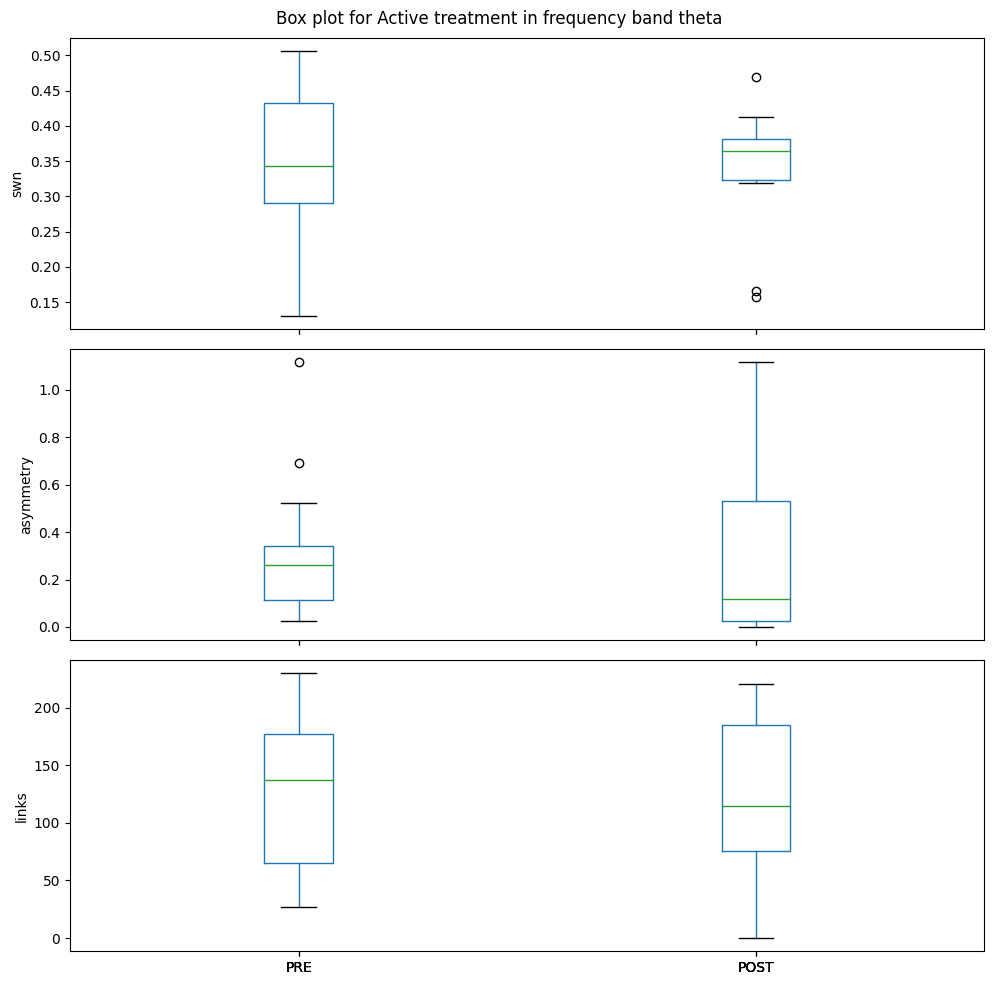

********* 0          NaN
1     0.328033
2          NaN
3     0.411041
4     0.505946
5     0.280962
6     0.130526
7     0.439336
8     0.318990
9     0.241701
10    0.446681
11    0.359716
Name: swn, dtype: float64 0          NaN
1     0.165424
2          NaN
3     0.318595
4     0.353311
5     0.157745
6     0.382258
7     0.374283
8     0.412563
9     0.380621
10    0.339589
11    0.468919
Name: swn, dtype: float64
swn, p-value: 0.8173875154071559
********* 0     0.692308
1     0.080000
2     0.281250
3     0.063694
4     0.237410
5     0.263158
6     0.257576
7     0.521277
8     0.280374
9     0.125000
10    1.115385
11    0.024390
Name: asymmetry, dtype: float64 0     0.000000
1     0.030303
2     0.000000
3     0.086420
4     0.153285
5     0.511628
6     1.115385
7     0.587302
8     0.937500
9     0.064516
10    0.018182
11    0.368421
Name: asymmetry, dtype: float64
asymmetry, p-value: 0.9709220406394015
********* 0      27.0
1     139.0
2      55.0
3     230.0
4     225.0
5 

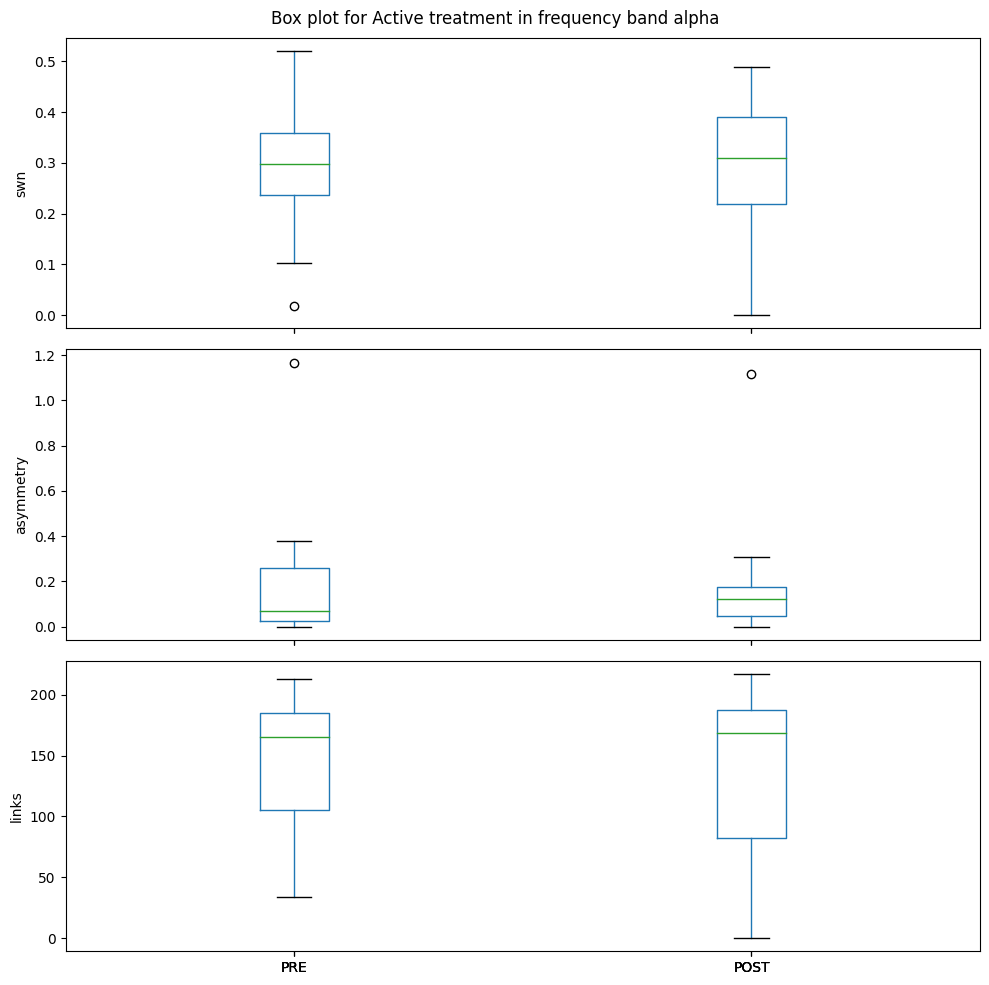

********* 0          NaN
1     0.367314
2     0.250996
3     0.351765
4     0.519844
5     0.103466
6     0.017914
7     0.343470
8     0.384051
9     0.222955
10    0.288658
11    0.297762
Name: swn, dtype: float64 0          NaN
1     0.286433
2     0.398823
3     0.243765
4     0.309701
5     0.193431
6     0.382258
7     0.000000
8     0.487908
9     0.322128
10    0.177686
11    0.436003
Name: swn, dtype: float64
swn, p-value: 0.8940893438129368
********* 0     1.166667
1     0.042553
2     0.008403
3     0.055118
4     0.380165
5     0.027778
6     0.333333
7     0.022472
8     0.000000
9     0.083333
10    0.166667
11    0.232323
Name: asymmetry, dtype: float64 0     0.000000
1     0.048387
2     0.041958
3     0.160305
4     0.141667
5     0.061224
6     1.115385
7     0.307692
8     0.104895
9     0.016529
10    0.145161
11    0.223214
Name: asymmetry, dtype: float64
asymmetry, p-value: 0.9223158569758687
********* 0      34.0
1     209.0
2     185.0
3     185.0
4     213.0
5 

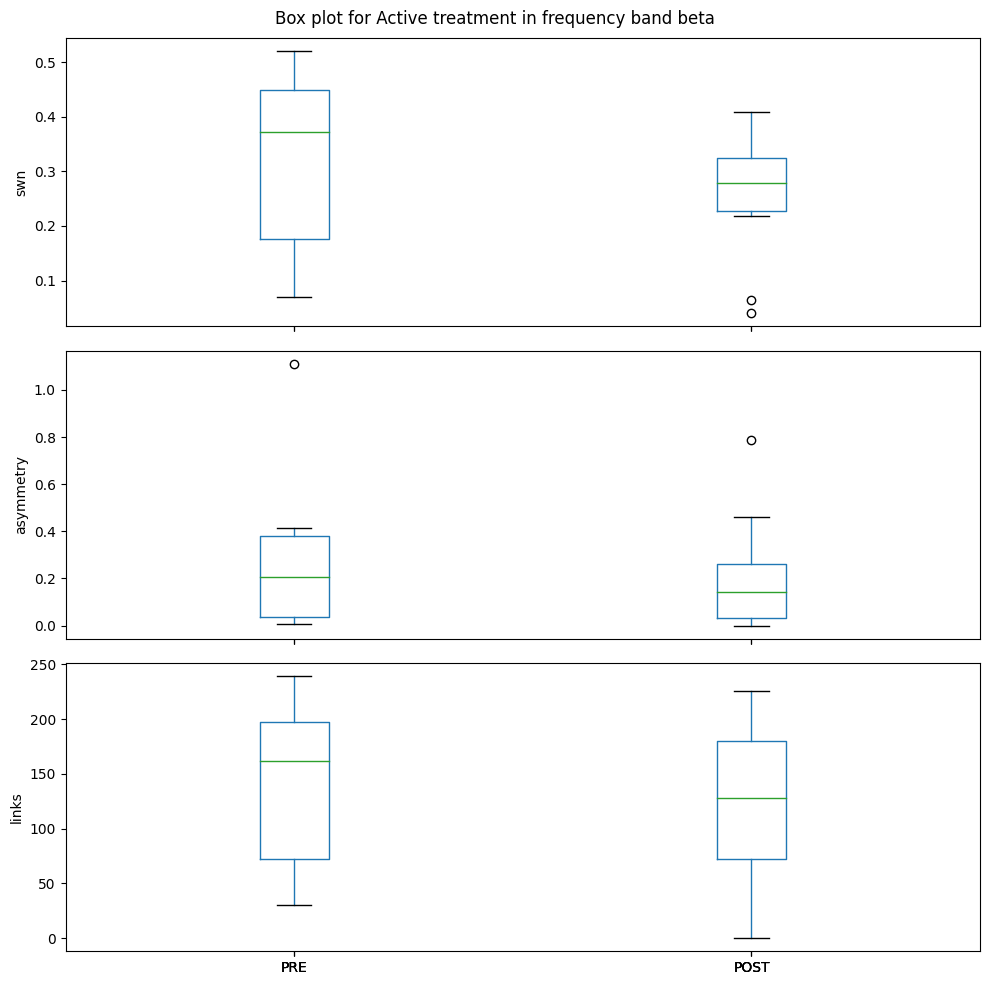

********* 0          NaN
1     0.350444
2          NaN
3     0.413731
4     0.520078
5     0.247594
6     0.151499
7     0.466029
8     0.070808
9     0.150152
10    0.460529
11    0.394298
Name: swn, dtype: float64 0          NaN
1     0.268773
2          NaN
3     0.300443
4     0.258649
5     0.063841
6     0.407903
7     0.217436
8     0.331982
9     0.388531
10    0.040811
11    0.288360
Name: swn, dtype: float64
swn, p-value: 0.4080944090473527
********* 0     0.176471
1     0.044248
2     0.378378
3     0.011976
4     0.415254
5     0.244898
6     0.013986
7     0.238806
8     0.008772
9     0.389831
10    1.111111
11    0.111111
Name: asymmetry, dtype: float64 0     0.000000
1     0.187500
2     0.000000
3     0.204545
4     0.040323
5     0.200000
6     0.078014
7     0.424242
8     0.459016
9     0.015748
10    0.787879
11    0.098039
Name: asymmetry, dtype: float64
asymmetry, p-value: 0.5077577255546762
********* 0      30.0
1     171.0
2      74.0
3     239.0
4     215.0
5 

In [26]:
for map in mapping: 
    g1_group_measures = pd.DataFrame({
        # master_dict['swn_values'][0][mapping[map]] can be replaced with swn_values1[mapping[map]]
        'swn': master_dict['swn_values'][0][mapping[map]],
        'links': master_dict['links_values'][0][mapping[map]],
        'asymmetry':  [abs(x - 1) for x in master_dict['asymmetry_values'][0][mapping[map]]]
    })


    g2_group_measures = pd.DataFrame({
        'swn': master_dict['swn_values'][1][mapping[map]],
        'links': master_dict['links_values'][1][mapping[map]],
        'asymmetry': [abs(x - 1) for x in master_dict['asymmetry_values'][1][mapping[map]]]
    })

    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    parameters = ['swn', 'asymmetry', 'links']

    for i, param in enumerate(parameters):
        print(mapping[map])
        df = pd.DataFrame({GROUP1: g1_group_measures[param], GROUP2: g2_group_measures[param]})
        df.boxplot(ax=axes[i], grid=False)
        # axes[i].boxplot([g1_group_measures[param], g2_group_measures[param]], labels=[GROUP1, GROUP2])
        axes[i].set_ylabel(param)

    fig.suptitle(f'Box plot for {ACTIVE_SHAM} treatment in frequency band {mapping[map]}')
    plt.tight_layout()
    plt.show()

    # Perform t-test for each parameter
    for param in parameters:
        print("*********", g1_group_measures[param], g2_group_measures[param])
        t_stat, p_value = ttest_rel(g1_group_measures[param].dropna(), g2_group_measures[param].dropna())
        print(f"{param}, p-value: {p_value}")
        if p_value < 0.05:
            print(f"Significant difference for parameter: {param} for freq band: {mapping[map]}")